## Setup

In [136]:
# References
# https://pythonfordatascience.org/anova-python/
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import xlsxwriter
import time
# import researchpy as rp

# Import internal modules
%run 4Pillars_Helpers.ipynb

# Set logging level
logger.setLevel(logging.INFO)
# Load data
diDfs = get_data(convert=False)
outcomes = [
    'FLU_VAX_RATE', 'FLU_MISSED_OPS_RATE', 'PNEUMO_VAX_RATE',
    'PNEUMO_MISSED_OPS_RATE', 'PCV_VAX_RATE', 'PCV_MISSED_OPS_RATE',
    'TDAP_VAX_RATE', 'TDAP_MISSED_OPS_RATE', 'TD_VAX_RATE',
    'TD_MISSED_OPS_RATE', 'ZOST_VAX_RATE', 'ZOST_MISSED_OPS_RATE'
]
vaxVars = ['FLU', 'PNEUMO', 'PCV', 'TDAP', 'TD', 'ZOST']

columnLabels = {
    'PAT_MRN_ID': 'Patient ID',
    'LOC_ID': 'Location ID',
    'AGE_60_64': '60-64',
    'AGE_65PLUS': 'Over 65',
    'BASELINE': 'Time period',
    'PHASE': 'Intervention phase',
    'BIRTH_DATE': 'Birth date',
    'FIRST_FLU_VISIT_DT': 'First visit of flu season',
    'FIRST_VISIT_DT': 'First visit during time period',
    'FLU_AT_VISIT': 'Flu vaccine administered at a visit',
    'FLU_BEFORE_FIRST_VIS': 'Flu vaccine before first visit',
    'FLU_ELIGIBLE': 'Flu vaccine eligible',
    'FLU_MISSED_OPS': 'Flu missed opportunities',
    'FLU_VACCINATED': 'Current flu immunization',
    'FLU_VACC_ELSEWHERE': 'Flu vaccine administered elsewhere',
    'LAST_FLU_DT': 'Last visit of flu season',
    'LAST_PCV_DT': 'Last PCV vaccination',
    'LAST_PNEUMO_DT': 'Last pneumo vaccination',
    'LAST_TDAP_DT': 'Last Tdap vaccination',
    'LAST_TD_DT': 'Last TD vaccination',
    'LAST_ZOST_DT': 'Last zoster vaccination',
    'NUM_FLU_ENCS': 'Visits during flu season',
    'NUM_OF_ENCS': 'Number of visits during time period',
    'PCV_AT_VISIT': 'PCV administered at a visit',
    'PCV_BEFORE_FIRST_VIS': 'PCV administered before first visit',
    'PCV_ELIGIBLE': 'PCV eligible',
    'PCV_MISSED_OPS': 'PCV missed opportunities',
    'PCV_VACCINATED': 'Current PCV immunization',
    'PCV_VACC_ELSEWHERE': 'PCV administered elsewhere',
    'PNEUMO_AT_VISIT': 'Pneumo vaccine administered at a visit',
    'PNEUMO_BEFORE_FIRST_VIS': 'Pneumo vaccine before first visit',
    'PNEUMO_ELIGIBLE': 'Pneumo vaccine eligible',
    'PNEUMO_MISSED_OPS': 'Pneumo missed opportunities',
    'PNEUMO_VACCINATED': 'Current pneumo immunization',
    'PNEUMO_VACC_ELSEWHERE': 'Pneumo vaccine administered elsewhere',
    'TDAP_AT_VISIT': 'Tdap administered at a visit',
    'TDAP_BEFORE_FIRST_VIS': 'Tdap administered before first visit',
    'TDAP_ELIGIBLE': 'Tdap vaccine eligible',
    'TDAP_MISSED_OPS': 'Tdap missed opportunities',
    'TDAP_VACCINATED': 'Current Tdap immunization',
    'TDAP_VACC_ELSEWHERE': 'Tdap vaccine administered elsewhere',
    'TD_AT_VISIT': 'Td administered at a visit',
    'TD_BEFORE_FIRST_VIS': 'Td administered before first visit',
    'TD_ELIGIBLE': 'Td vaccine eligible',
    'TD_MISSED_OPS': 'Td missed opportunities',
    'TD_VACCINATED': 'Current Td immunization',
    'TD_VACC_ELSEWHERE': 'Td administered elsewhere',
    'ZOST_AT_VISIT': 'Zoster vaccine administered at a visit',
    'ZOST_BEFORE_FIRST_VIS': 'Zoster vaccine administered before first visit',
    'ZOST_ELIGIBLE': 'Zoster vaccine eligible',
    'ZOST_MISSED_OPS': 'Zoster vaccine missed opportunities',
    'ZOST_VACCINATED': 'Current zoster immunization',
    'ZOST_VACC_ELSEWHERE': 'Zoster vaccine administered elsewhere',
    'FLU_VAX_RATE': 'Flu vaccination rate',
    'FLU_MISSED_OPS_RATE': 'Flu vaccine missed opportunities rate',
    'PNEUMO_VAX_RATE': 'Pneumo vaccination rate',
    'PNEUMO_MISSED_OPS_RATE': 'Pneumo vaccine missed opportunities rate',
    'PCV_VAX_RATE': 'PCV vaccination rate',
    'PCV_MISSED_OPS_RATE': 'PCV vaccine missed opportunities rate',
    'TDAP_VAX_RATE': 'Tdap vaccination rate',
    'TDAP_MISSED_OPS_RATE': 'Tdap vaccine missed opportunities rate',
    'TD_VAX_RATE': 'Td vaccination rate',
    'TD_MISSED_OPS_RATE': 'Td vaccine missed opportunities rate',
    'ZOST_VAX_RATE': 'Zoster vaccination rate',
    'ZOST_MISSED_OPS_RATE': 'Zoster vaccine missed opportunities rate',
    'WIC': 'Walk-in-clinic',
    'FLU': 'Influenza',
    'PNEUMO': 'Pneumo',
    'TDAP': 'Tdap',
    'TD': 'Td',
    'ZOST': 'Zoster',
    'AT_VISIT': 'Vaccine administered at a visit',
    'BEFORE_FIRST_VIS': 'Vaccine administered before first visit',
    'ELIGIBLE': 'Vaccine eligible',
    'MISSED_OPS': 'Vaccine missed opportunities',
    'VACCINATED': 'Immunized',
    'VACC_ELSEWHERE': 'Vaccine administered elsewhere',
    'VAX_RATE': 'Vaccination rate',
    'MISSED_OPS_RATE': 'Vaccine missed opportunities rate',
    'df': 'Df',
    'N_PATIENT': 'Patients',
    'sum_sq': 'Sum sq',
    'Date of intervention': 'Start date of intervention',
    'PHASE': 'Phase'
}

Automatic pdb calling has been turned OFF
Exception reporting mode: Plain
home = /mnt/c/users/jravi
projectRoot = /mnt/d/Documents/Repos/4Pillars_Outcomes
Cannot locate Box Sync directory.
dirBox = /mnt/c/users/jravi/Documents/Box Sync
dirDataPrivate = /mnt/c/users/jravi/Documents/Box Sync/data/cmi
dirDataPublic = /mnt/d/Documents/Repos/4Pillars_Outcomes/data
dirDataEpic = /mnt/c/users/jravi/Documents/Box Sync/data/cmi/epic


INFO - get_results_from_pickle - Using stored data from /mnt/c/users/jravi/Documents/Box Sync/data/cmi/epic/rawData.p
INFO - ingest_raw_data - Loaded raw data.
INFO - get_results_from_pickle - Using stored data from /mnt/c/users/jravi/Documents/Box Sync/data/cmi/epic/di.p
INFO - create_practice_list - Practice info processed
INFO - get_results_from_pickle - Using stored data from /mnt/c/users/jravi/Documents/Box Sync/data/cmi/epic/dfCombined.p
INFO - get_results_from_pickle - Using stored data from /mnt/c/users/jravi/Documents/Box Sync/data/cmi/epic/di2.p
INFO - get_results_from_pickle - Using stored data from /mnt/c/users/jravi/Documents/Box Sync/data/cmi/epic/di3.p
INFO - get_results_from_pickle - Using stored data from /mnt/c/users/jravi/Documents/Box Sync/data/cmi/epic/di4.p
INFO - get_data - 
 DataFrames available:
['dfCombined', 'dfWithWic', 'dfNoWic', 'dfDropWic', 'dfSites', 'dfWithWic_Outcomes_Locs', 'dfWithWic_Outcomes_Baseline', 'dfNoWic_Outcomes_Locs', 'dfNoWic_Outcomes_Base

## Data
* Data is available in the dictionary `diDfs`. DataFrames can be selected by index as `diDfs['dfIndex']`.
* Underscores (`_`) precede an aggregated feature (`_Outcomes`) then the aggregation level. (`_Locs`).
* `dfCombined` contains all cleaned EMR data in tidy format.
    * `dfWithWic` excludes walk-in-clinic departments, but retains patients with visits to that department.
    * `dfNoWic` excludes walk-in-clinic departments and all patients with visits to the that department.
    * `dfDropWic` excludes all locations with >= 5% difference between the first two strategies.
* `dfSites` contains all practice information in tidy format.
    * `dfSites_Locs` is practice information aggregated to location-level.

### Patient-level data
Patient-level data came aggregated to the time period and location. A location is a group of billing departments that roll up to a single billing entity. For example a location may include Dr. Smith's East Office, Dr. Smith's West Office and Dr. Smith's Walk-in-clinics at both offices. A partial selection of the dataset is shown below.
* Columns show the variables collected from Epic including:  
    * the date of the first visit the patient had to any department within the Location during the time frame  
    * the total number of encounters to any department(s) of the location during the time frame  
    * vaccination status before the first visit of the time frame  
    * vaccine eligibility  
    * vaccine administration during the time frame  
    * vaccine administration at a visit  
* Vaccination outcomes
    * `_VAX_RATE` is ratio of vaccinated patients to total location population
    * `_MISSED_OPS_RATE` is the ratio of visits by unvaccinated patients to total visits  

In [137]:
# Redacted for privacy
# diDfs['dfCombined'].set_index(
#     ['PAT_MRN_ID', 'BASELINE', 'LOC_ID', 'DEPT_ID',
#      'PRACTICE']).sort_index().head()

###  Location-level aggregated data
The patient-level data is aggregated to the location using sum, min, or max as noted in the source code.  
* Each row is a location.
* N = the count of patients with at least one visit to any department in the location.

In [138]:
# Redacted for privancy
# diDfs['dfWithWic'].set_index(['BASELINE', 'LOC_ID']).head()

### Site information

In [139]:
# Redacted for privacy
# diDfs['dfSites']

## Analyses

### Differences between WIC & NoWIC
Location data was aggregated using two different strategies to tabulate visits to the walk-in-clinics. Due to the structure of the available data, excluding visits to the walk-in-clinics may or may not bias results for the location. Vaccination outcomes may differ in this department for several reasons. From a provider perspective, walk-in-clinic appointments are focused more on an emergent conditions and less on preventive care. Though vaccination is rarely contra-indicated by the typical conditions addressed in walk-in-clinics, it may be overshadowed by more urgent complaints. Similarly, from a patient perspective, vaccination at a walk-in-clinic visit may be perceived as too burdensome to consider while injured or ill. Likelihood of vaccination may also vary from other departments as not all patients seen in a location's walk-in-clinic are necessarily primary care patients at the location. That is, patients whose primary care provider practices at the location often seek urgent treatment at the location's walk-in-clinic, but the reverse may not be true.

To assess the impact of two strategies for aggregating patient-level data to location data, a test of the conditions is necessary.  
* Strategy 1 (Filter) returns a data set which includes patients seen in the locations' walk-in-clinics in the aggregated location counts. If a large proportion of walk-in patients do not also visit the location for preventive services, the population served by the clinic will include a number of visits where assessment of vaccination may differ from its priority during a scheduled visit. Consequently, the location will show more missed opportunities if walk-in visits do not consider vaccine status with the same importance as during primary care visits.  
* Strategy 2 (Exclude) returns a data set which excludes patients seen in walk-in-clinics from location visit counts. This eliminates the count of visits from patients whose medical home resides elsewhere, but penalizes sites who do prioritize vaccination at walk-in clinics. For example locations who code drop-in vaccination clinics as walk-in visits or whose clinical staff do use urgent care visits as an opportunity to vaccinate, will not be credited for these efforts.  
* Strategy 3 (Drop) returns a data set which excludes all locations with more than a 5% difference between patient counts produced by strategy 1 and strategy 2.

Analysis below shows that all strategies yield similar results. Data from strategy 2 will be used for the remainder of analyses.

#### Does strategy for aggregating WIC visits matter?
No
Charts below compare the 3 strategies to aggregate results with the available data.
All 3 strategies yield similar distributions.
ANOVAs are significant for the same outcomes

Conclusion: Use Strategy 2 (`dfNoWic`) which represents the desired context

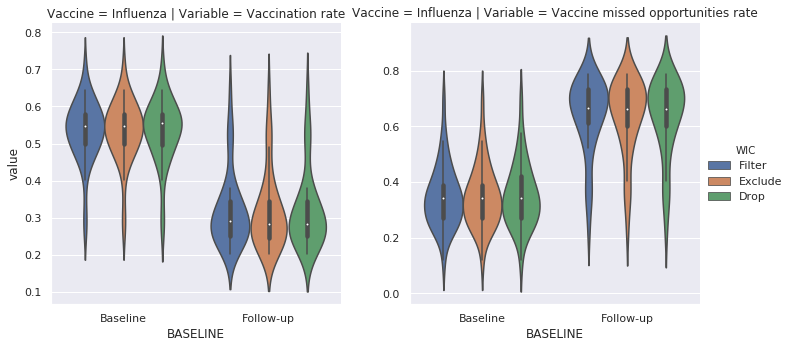

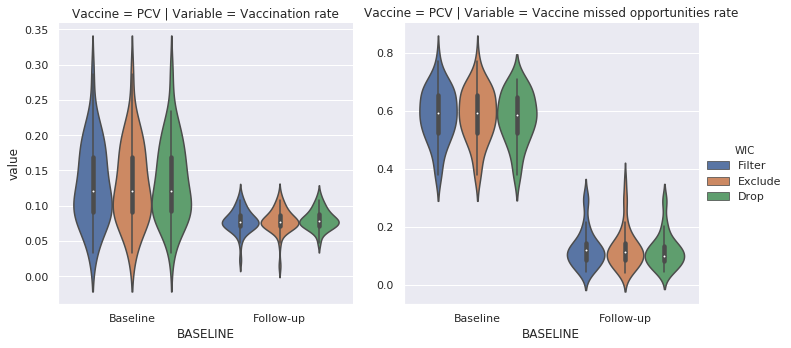

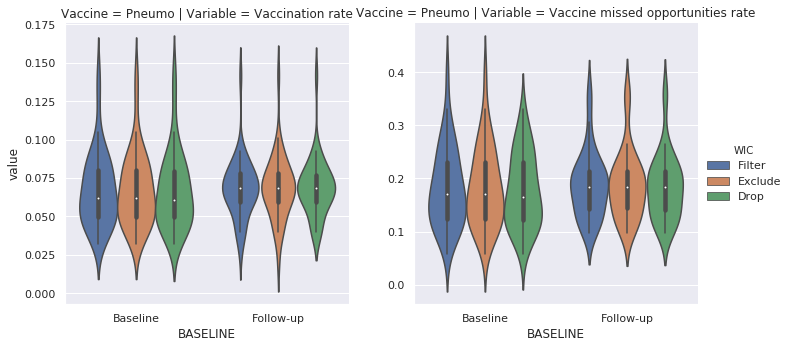

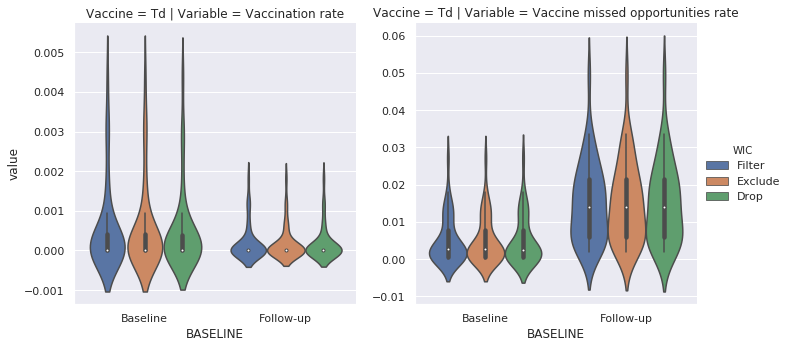

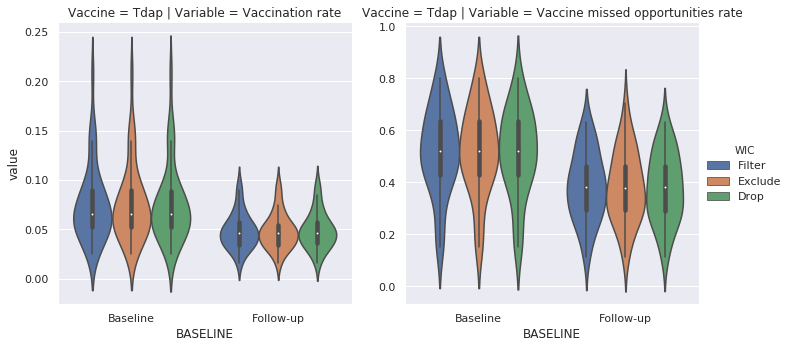

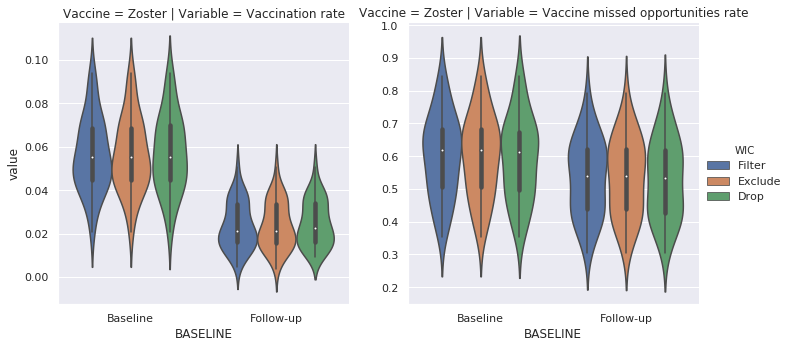

In [140]:
dfDropWic_Outcomes_Locs = diDfs['dfDropWic_Outcomes_Locs']
dfDropWic_Outcomes_Locs['WIC'] = 'Drop'
dfNoWic_Outcomes_Locs = diDfs['dfNoWic_Outcomes_Locs']
dfNoWic_Outcomes_Locs['WIC'] = 'Exclude'
dfWithWic_Outcomes_Locs = diDfs['dfWithWic_Outcomes_Locs']
dfWithWic_Outcomes_Locs['WIC'] = 'Filter'
data = pd.concat(
    [dfWithWic_Outcomes_Locs, dfNoWic_Outcomes_Locs, dfDropWic_Outcomes_Locs])
idCols = ['BASELINE', 'LOC_ID', 'WIC']
cols = idCols + outcomes

df = data.melt(id_vars=idCols, value_vars=outcomes)
df[['Vaccine', 'Variable']] = df['variable'].str.split('_', n=1, expand=True)

df = df.replace(columnLabels)

df['BASELINE'] = df['BASELINE'].replace({True: 'Baseline', False: 'Follow-up'})
df['Variable'] = df['Variable'].replace({
    'VAX_RATE':
    'Vaccination rate',
    'MISSED_OPS_RATE':
    'Missed opportunities rate'
})

timestr = time.strftime("%Y%m%d-%H%M")
for vax, df in df.groupby(['Vaccine']):
    plot = sns.catplot(x='BASELINE',
                       order=['Baseline', 'Follow-up'],
                       y="value",
                       kind='violin',
                       hue='WIC',
                       col="Variable",
                       row='Vaccine',
                       sharex=True,
                       sharey=False,
                       margin_titles=False,
                       data=df)
    plt.show(plot)
#     plot.savefig(os.path.join(projectRoot, 'reports', 'figures', 'plt_violin_' + vax + "_" + timestr + '.png'))

In [141]:
groupedWic = get_patient_counts(diDfs['dfWithWic'])
groupedNoWic = get_patient_counts(diDfs['dfNoWic'])
df = groupedWic.join(groupedNoWic, rsuffix='_rt').rename(
    columns={
        'Patient count': 'Patient count with WIC (Strategy 1)',
        'Patient count_rt': 'Patient count without WIC (Strategy 2)'
    })

df['Percent Difference'] = (df['Patient count with WIC (Strategy 1)'] -
                            df['Patient count without WIC (Strategy 2)']) / (
                                df['Patient count with WIC (Strategy 1)'] +
                                df['Patient count without WIC (Strategy 2)'])
print('Differing patient counts from alternative handling of WIC.')
df = df[df['Percent Difference'] > 0].query(
    'BASELINE != "**Total**"').reset_index().sort_values('Percent Difference')
df = df.sort_values('Percent Difference')
df['> 0.05 Difference'] = np.where(df['Percent Difference'] > .05, '*',
                                         '')
print('Locations with >= .05 Difference')
df.index.name = 'Site ID'
df.iloc[:, 2:].to_excel(
    os.path.join(projectRoot, 'reports', 'tables', 'wic-strategies.xlsx'))
df.iloc[:, 2:]
df = df[df['Percent Difference'] > .05].query(
    'BASELINE != "**Total**"').reset_index().sort_values('Percent Difference')
locFilter = list(df['LOC_ID'])
locFilter

Differing patient counts from alternative handling of WIC.
Locations with >= .05 Difference


[11207, 1145, 11156, 11131]

### Descriptives

#### Intervention dates

In [142]:
dfFirstDates = diDfs['dfCombined'].groupby(['BASELINE']).agg({
    'FIRST_VISIT_DT':
    'min',
    'FIRST_FLU_VISIT_DT':
    'min',
    'LAST_FLU_DT':
    'max'
}).reset_index()

dfFirstDates[dfFirstDates['BASELINE'] == 'Baseline']
sites = diDfs['dfSites'].groupby('PHASE').agg({
    'Date of intervention': 'min',
    'LOC_ID': 'count'
}).reset_index().rename(
    columns={
        'PHASE': 'Phase',
        'Date of intervention': 'Intervention start',
        'LOC_ID': 'Location count'
    })
display(sites)
display('Total locations = ' + str(sites['Location count'].sum()))
dfFirstDates[dfFirstDates['BASELINE'] == 'Follow-up']

,Phase,Intervention start,Location count
0,1.0,2015-04-08,14
1,2.0,2014-05-31,13
2,3.0,2015-08-16,21
3,4.0,2016-10-19,13
4,5.0,2017-05-06,2


'Total locations = 63'

,BASELINE,FIRST_VISIT_DT,FIRST_FLU_VISIT_DT,LAST_FLU_DT
1,Follow-up,2017-04-01,2017-08-01,2018-03-28


#### Descriptors

In [143]:
# Prepare a dataframe
dfData = diDfs['dfNoWic'][['LOC_ID', 'BASELINE', 'PAT_MRN_ID', 'Age']].copy()

# Merge with phase information (assumes locations that span multiple phases are classified in the first phase)
dfSites = diDfs['dfSites'][[
    'LOC_ID', 'PHASE', 'Date of intervention'
]].dropna().drop_duplicates().groupby(['LOC_ID']).agg({
    'Date of intervention': 'first',
    'PHASE': 'first'
}).reset_index()
dfData = pd.merge(left=dfData, right=dfSites, on='LOC_ID')

##### By Timepoint

In [144]:
ageXtime = pd.crosstab(dfData['BASELINE'],
                       dfData['Age'],
                       margins=True,
                       margins_name='Total',
                       rownames=[None],
                       colnames=[""])

display(ageXtime.style.format("{:,}"))
ageXtime.to_excel(
    os.path.join(projectRoot, 'reports', 'tables', 'ageXtime.xlsx'))

,60-64,65+,Total
Baseline,"19,359","51,144","70,503"
Follow-up,"21,736","59,342","81,078"
Total,"41,095","110,486","151,581"


##### By Phase

In [145]:
df = dfData[dfData['BASELINE'] == 'Baseline']
phaseXage = pd.crosstab(df['PHASE'],
                        df['Age'],
                        margins=True,
                        margins_name='Total',
                        rownames=[None],
                        colnames=[""])
phaseXage = phaseXage.merge(sites.set_index(['Phase']),
                            left_index=True,
                            right_index=True).append(
                                phaseXage.loc['Total', :]).fillna('')
display(phaseXage)
phaseXage.to_excel(
    os.path.join(projectRoot, 'reports', 'tables', 'phaseXage.xlsx'))

,60-64,65+,Total,Intervention start,Location count
1.0,4970.0,13101.0,18071.0,2015-04-08 00:00:00,14
2.0,4601.0,11851.0,16452.0,2014-05-31 00:00:00,13
3.0,5577.0,14139.0,19716.0,2015-08-16 00:00:00,21
4.0,3398.0,10122.0,13520.0,2016-10-19 00:00:00,13
5.0,813.0,1931.0,2744.0,2017-05-06 00:00:00,2
Total,19359.0,51144.0,70503.0,,


##### By location
See below

#### All Location-level outcomes

In [146]:
dfData = diDfs['dfNoWic_Outcomes_Locs']
# dfData = diDfs['dfNoWic']
vaxVars = ['FLU', 'PNEUMO', 'PCV', 'TDAP', 'TD', 'ZOST']


def format_with_multiindex(df,
                           fmt,
                           multiRows=pd.IndexSlice[:],
                           multiCols=pd.IndexSlice[:]):
    """Formats specified values of a multi-indexed dataframe in place
    
    """
    df.loc[multiRows, multiCols] = df.loc[multiRows, multiCols].applymap(
        fmt.format)
    return df

# Combined dataset
dfComb = pd.DataFrame()
# Perform aggregations and summarize by vaccine then generate summary table
for vax in vaxVars:
    # restrict encounters for flu season
    if vax == 'FLU':
        encs = 'NUM_FLU_ENCS'
    else:
        encs = 'NUM_OF_ENCS'
    # Gather columns for the vaccine
    cols = ['BASELINE', 'LOC_ID', 'N_PATIENT', encs]
    cols.extend([
        c for c in list(dfData)
        if ((c.split('_', 1)[0] == vax) and ("_DT" not in c))
    ])
    # Start with empty dataframe
    df = pd.DataFrame()
    # Rename flu encs column so concat works
    df = dfData[cols].rename(columns={'NUM_FLU_ENCS': 'NUM_OF_ENCS'})
    # Converts vaccine-specific outcome list to general outcomes dict for column renaming
    cols = {
        col: col.split('_', 1)[1] if col.split('_', 1)[0] == vax else col
        for col in cols
    }
    df = df.rename(columns=cols).rename(columns=columnLabels).rename(
        columns={'N_PATIENT': 'Patients'})
    # Reorder columns
    df = df.reindex([
        'Time period', 'Patients', 'Number of visits during time period',
        'Vaccine eligible', 'Vaccine administered at a visit',
        'Vaccine administered elsewhere', 'Immunized',
        'Vaccine missed opportunities', 'Vaccination rate',
        'Vaccine missed opportunities rate'
    ],
                    axis=1)
    df = df.groupby(['Time period',
                     ]).agg(['sum', 'mean', 'std', 'min', 'max', 'median'])
    if vax != "PCV":
        df['Vaccine'] = vax.capitalize()
    else:
        df['Vaccine'] = vax
    df.set_index('Vaccine', append=True, inplace=True)
    dfComb = dfComb.append(df).sort_index()
# Drop sums that don't make sense
dfComb.drop([('Vaccination rate', 'sum'),
             ('Vaccine missed opportunities rate', 'sum')],
            axis=1,
            inplace=True)
# Format columns
idx = pd.IndexSlice
dfComb = format_with_multiindex(
    dfComb, multiCols=idx[:"Vaccine missed opportunities", :], fmt="{:,.2f}")
dfComb = format_with_multiindex(dfComb,
                                multiCols=idx["Vaccination rate":, :],
                                fmt="{:,.4f}")
display(dfComb)

# https://pbpython.com/improve-pandas-excel-output.html
writer = pd.ExcelWriter(os.path.join(projectRoot, 'reports', 'tables',
                                     'combined_outcomes.xlsx'))
#                         engine='xlsxwriter')
dfComb.to_excel(writer, sheet_name='combined')

for c in list(dfComb.columns.levels[0]):
    if c == 'Vaccine':
        pass
    else:
        df = dfComb.loc[:,slice(c,c)]
        display(df)
        df.to_excel(writer, c[:15].replace(" ", "_"))
writer.save()

Patients                                                 Number of visits during time period                                                    Vaccine eligible                                                 Vaccine administered at a visit                                           Vaccine administered elsewhere                                        Immunized                                           Vaccine missed opportunities                                                  Vaccination rate                                 Vaccine missed opportunities rate                                
                           sum      mean       std     min       max    median                                 sum      mean       std       min        max    median              sum      mean       std     min       max    median                             sum    mean     std     min       max  median                            sum    mean    std    min     max  median        sum    mean     std     min       max  median                          sum      mean       std     min        max    median             mean     std     min     max  median                              mean     std     min     max  median
Time period Vaccine                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
Baseline    Flu      70,503.00  1,762.58  1,142.25  260.00  5,908.00  1,487.50                          164,971.00  4,124.27  2,923.96    847.00  14,968.00  3,299.00        55,838.00  1,395.95    910.70  209.00  4,745.00  1,228.00                       32,922.00  823.05  569.44  147.00  2,741.00  642.50                       4,877.00  121.92  87.01   5.00  374.00  107.50  37,799.00  944.98  648.66  152.00  3,115.00  737.50                    54,764.00  1,369.10    992.82  237.00   5,146.00  1,302.50           0.5339  0.0834  0.2662  0.7071  0.5462                            0.3476  0.1112  0.1188  0.6932  0.3424
            PCV      70,503.00  1,762.58  1,142.25  260.00  5,908.00  1,487.50                          246,921.00  6,173.02  4,309.30  1,284.00  22,059.00  5,038.50        50,420.00  1,260.50    823.65  151.00  4,132.00  1,068.00                        8,753.00  218.82  181.48   23.00    670.00  152.50                         708.00   17.70  14.03   0.00   52.00   13.50   9,461.00  236.53  190.13   23.00    718.00  157.00                   144,997.00  3,624.93  2,573.12  491.00  13,085.00  2,978.00           0.1310  0.0569  0.0325  0.2870  0.1206                            0.5843  0.0917  0.3774  0.7710  0.5908
            Pneumo   70,503.00  1,762.58  1,142.25  260.00  5,908.00  1,487.50                          246,921.00  6,173.02  4,309.30  1,284.00  22,059.00  5,038.50        17,346.00    433.65    320.74   45.00  1,677.00    381.50                        4,176.00  104.40   83.42   18.00    333.00   79.50                         530.00   13.25  10.31   2.00   53.00   11.00   4,706.00  117.65   91.99   21.00    369.00   90.50                    43,506.00  1,087.65    823.54  136.00   4,389.00  1,015.50           0.0674  0.0240  0.0321  0.1435  0.0620                            0.1824  0.0743  0.0584  0.3976  0.1711
            Td       70,503.00  1,762.58  1,142.25  260.00  5,908.00  1,487.50                          246,921.00  6,173.02  4,309.30  1,284.00  22,059.00  5,038.50           337.00      8.43     10.67    0.00     50.00      5.00                           13.00    0.33    0.86    0.00      4.00    0.

Patients                                                
                           sum      mean       std     min       max    median
Time period Vaccine                                                           
Baseline    Flu      70,503.00  1,762.58  1,142.25  260.00  5,908.00  1,487.50
            PCV      70,503.00  1,762.58  1,142.25  260.00  5,908.00  1,487.50
            Pneumo   70,503.00  1,762.58  1,142.25  260.00  5,908.00  1,487.50
            Td       70,503.00  1,762.58  1,142.25  260.00  5,908.00  1,487.50
            Tdap     70,503.00  1,762.58  1,142.25  260.00  5,908.00  1,487.50
            Zost     70,503.00  1,762.58  1,142.25  260.00  5,908.00  1,487.50
Follow-up   Flu      81,078.00  2,026.95  1,271.17  338.00  6,363.00  1,740.00
            PCV      81,078.00  2,026.95  1,271.17  338.00  6,363.00  1,740.00
            Pneumo   81,078.00  2,026.95  1,271.17  338.00  6,363.00  1,740.00
            Td       81,078.00  2,026.95  1,271.17  338.00  6,363.00  1,740.00
            Tdap     81,078.00  2,026.95  1,271.17  338.00  6,363.00  1,740.00
            Zost     81,078.00  2,026.95  1,271.17  338.00  6,363.00  1,740.00

Number of visits during time period                                                   
                                                    sum      mean       std       min        max    median
Time period Vaccine                                                                                       
Baseline    Flu                              164,971.00  4,124.27  2,923.96    847.00  14,968.00  3,299.00
            PCV                              246,921.00  6,173.02  4,309.30  1,284.00  22,059.00  5,038.50
            Pneumo                           246,921.00  6,173.02  4,309.30  1,284.00  22,059.00  5,038.50
            Td                               246,921.00  6,173.02  4,309.30  1,284.00  22,059.00  5,038.50
            Tdap                             246,921.00  6,173.02  4,309.30  1,284.00  22,059.00  5,038.50
            Zost                             246,921.00  6,173.02  4,309.30  1,284.00  22,059.00  5,038.50
Follow-up   Flu                              191,584.00  4,789.60  3,266.89    935.00  17,223.00  3,908.50
            PCV                              282,279.00  7,056.98  4,695.81  1,420.00  24,402.00  5,746.00
            Pneumo                           282,279.00  7,056.98  4,695.81  1,420.00  24,402.00  5,746.00
            Td                               282,279.00  7,056.98  4,695.81  1,420.00  24,402.00  5,746.00
            Tdap                             282,279.00  7,056.98  4,695.81  1,420.00  24,402.00  5,746.00
            Zost                             282,279.00  7,056.98  4,695.81  1,420.00  24,402.00  5,746.00

Vaccine eligible                                                
                                 sum      mean       std     min       max    median
Time period Vaccine                                                                 
Baseline    Flu            55,838.00  1,395.95    910.70  209.00  4,745.00  1,228.00
            PCV            50,420.00  1,260.50    823.65  151.00  4,132.00  1,068.00
            Pneumo         17,346.00    433.65    320.74   45.00  1,677.00    381.50
            Td                337.00      8.43     10.67    0.00     50.00      5.00
            Tdap           43,154.00  1,078.85    722.84   66.00  3,461.00  1,017.00
            Zost           46,725.00  1,168.12    769.57  173.00  3,717.00  1,078.50
Follow-up   Flu            65,029.00  1,625.72  1,053.50  266.00  5,246.00  1,371.00
            PCV            17,218.00    430.45    330.24   50.00  1,848.00    341.00
            Pneumo         21,258.00    531.45    381.56   66.00  2,027.00    458.50
            Td              1,221.00     30.52     30.06    3.00    133.00     19.00
            Tdap           36,031.00    900.77    623.61   72.00  3,357.00    770.00
            Zost           47,040.00  1,176.00    789.11  182.00  4,258.00  1,012.50

Vaccine administered at a visit                                          
                                                sum    mean     std     min       max  median
Time period Vaccine                                                                          
Baseline    Flu                           32,922.00  823.05  569.44  147.00  2,741.00  642.50
            PCV                            8,753.00  218.82  181.48   23.00    670.00  152.50
            Pneumo                         4,176.00  104.40   83.42   18.00    333.00   79.50
            Td                                13.00    0.33    0.86    0.00      4.00    0.00
            Tdap                           4,993.00  124.83  127.82    7.00    748.00  102.50
            Zost                           2,176.00   54.40   49.14    4.00    231.00   39.50
Follow-up   Flu                           20,368.00  509.20  404.41  106.00  2,241.00  391.50
            PCV                            5,692.00  142.30   87.74   13.00    370.00  121.50
            Pneumo                         5,068.00  126.70   90.07   17.00    418.00  102.50
            Td                                 2.00    0.05    0.22    0.00      1.00    0.00
            Tdap                           2,954.00   73.85   48.59   11.00    209.00   64.00
            Zost                           1,168.00   29.20   27.07    1.00    120.00   19.00

Vaccine administered elsewhere                                      
                                               sum    mean    std    min     max  median
Time period Vaccine                                                                     
Baseline    Flu                           4,877.00  121.92  87.01   5.00  374.00  107.50
            PCV                             708.00   17.70  14.03   0.00   52.00   13.50
            Pneumo                          530.00   13.25  10.31   2.00   53.00   11.00
            Td                               20.00    0.50   1.01   0.00    4.00    0.00
            Tdap                            619.00   15.47  13.66   1.00   59.00   12.00
            Zost                          1,640.00   41.00  28.36   7.00  131.00   33.00
Follow-up   Flu                           4,634.00  115.85  76.01  15.00  359.00   98.00
            PCV                             508.00   12.70   8.42   1.00   33.00   10.50
            Pneumo                          456.00   11.40   7.31   1.00   30.00   10.00
            Td                                8.00    0.20   0.41   0.00    1.00    0.00
            Tdap                            769.00   19.23  18.47   2.00   84.00   14.00
            Zost                            641.00   16.02  12.59   1.00   50.00   12.50

Immunized                                          
                           sum    mean     std     min       max  median
Time period Vaccine                                                     
Baseline    Flu      37,799.00  944.98  648.66  152.00  3,115.00  737.50
            PCV       9,461.00  236.53  190.13   23.00    718.00  157.00
            Pneumo    4,706.00  117.65   91.99   21.00    369.00   90.50
            Td           33.00    0.82    1.32    0.00      5.00    0.00
            Tdap      5,612.00  140.30  137.23    9.00    807.00  118.00
            Zost      3,816.00   95.40   67.97   16.00    362.00   83.50
Follow-up   Flu      25,002.00  625.05  466.09  123.00  2,600.00  499.50
            PCV       6,200.00  155.00   93.93   16.00    388.00  132.50
            Pneumo    5,524.00  138.10   95.16   18.00    448.00  110.50
            Td           10.00    0.25    0.49    0.00      2.00    0.00
            Tdap      3,723.00   93.08   59.41   15.00    219.00   79.00
            Zost      1,809.00   45.23   35.29    5.00    164.00   32.00

Vaccine missed opportunities                                                 
                                             sum      mean       std     min        max    median
Time period Vaccine                                                                              
Baseline    Flu                        54,764.00  1,369.10    992.82  237.00   5,146.00  1,302.50
            PCV                       144,997.00  3,624.93  2,573.12  491.00  13,085.00  2,978.00
            Pneumo                     43,506.00  1,087.65    823.54  136.00   4,389.00  1,015.50
            Td                          1,201.00     30.02     47.44    0.00     217.00     16.50
            Tdap                      126,943.00  3,173.57  2,183.44  192.00   9,603.00  2,758.00
            Zost                      143,390.00  3,584.75  2,448.82  636.00  11,339.00  2,947.50
Follow-up   Flu                       123,275.00  3,081.88  2,138.81  356.00   8,850.00  2,767.50
            PCV                        34,739.00    868.48    812.19  118.00   4,639.00    627.50
            Pneumo                     53,012.00  1,325.30  1,038.25  160.00   5,802.00  1,143.50
            Td                          4,006.00    100.15    107.84    4.00     491.00     63.50
            Tdap                      107,617.00  2,690.43  1,875.10  157.00   9,706.00  2,296.50
            Zost                      148,025.00  3,700.62  2,446.19  625.00  12,651.00  3,089.50

Vaccination rate                                
                                mean     std     min     max  median
Time period Vaccine                                                 
Baseline    Flu               0.5339  0.0834  0.2662  0.7071  0.5462
            PCV               0.1310  0.0569  0.0325  0.2870  0.1206
            Pneumo            0.0674  0.0240  0.0321  0.1435  0.0620
            Td                0.0006  0.0011  0.0000  0.0044  0.0000
            Tdap              0.0755  0.0381  0.0249  0.2083  0.0653
            Zost              0.0562  0.0169  0.0209  0.0940  0.0554
Follow-up   Flu               0.3169  0.1038  0.2013  0.6432  0.2839
            PCV               0.0783  0.0170  0.0147  0.1150  0.0769
            Pneumo            0.0685  0.0204  0.0206  0.1417  0.0683
            Td                0.0002  0.0004  0.0000  0.0018  0.0000
            Tdap              0.0484  0.0180  0.0161  0.0962  0.0467
            Zost              0.0236  0.0108  0.0037  0.0508  0.0210

Vaccine missed opportunities rate                                
                                                 mean     std     min     max  median
Time period Vaccine                                                                  
Baseline    Flu                                0.3476  0.1112  0.1188  0.6932  0.3424
            PCV                                0.5843  0.0917  0.3774  0.7710  0.5908
            Pneumo                             0.1824  0.0743  0.0584  0.3976  0.1711
            Td                                 0.0051  0.0063  0.0000  0.0271  0.0026
            Tdap                               0.5170  0.1642  0.1495  0.8015  0.5178
            Zost                               0.6006  0.1248  0.3521  0.8446  0.6187
Follow-up   Flu                                0.6362  0.1363  0.2305  0.7888  0.6635
            PCV                                0.1255  0.0678  0.0424  0.3561  0.1143
            Pneumo                             0.1883  0.0643  0.0971  0.3633  0.1830
            Td                                 0.0151  0.0108  0.0019  0.0494  0.0140
            Tdap                               0.3831  0.1370  0.1106  0.7027  0.3762
            Zost                               0.5363  0.1195  0.3049  0.7921  0.5399

In [147]:
idx = pd.IndexSlice
cols = (['Patients', 'Vaccine eligible', 'Immunized', 'Vaccination rate'], [
    'Number of visits during time period', 'Vaccine administered at a visit',
    'Vaccine missed opportunities rate'
])
for ls in cols:
    df = dfComb.loc[idx[:, :, ], idx[ls, ['mean', 'std']]]
    display(df)
    #     df.to_excel(os.path.join(projectRoot, 'reports', 'tables', 'outcomes'+ str(len(ls)) +'.xlsx'))

Patients           Vaccine eligible           Immunized         Vaccination rate        
                         mean       std             mean       std      mean     std             mean     std
Time period Vaccine                                                                                          
Baseline    Flu      1,762.58  1,142.25         1,395.95    910.70    944.98  648.66           0.5339  0.0834
            PCV      1,762.58  1,142.25         1,260.50    823.65    236.53  190.13           0.1310  0.0569
            Pneumo   1,762.58  1,142.25           433.65    320.74    117.65   91.99           0.0674  0.0240
            Td       1,762.58  1,142.25             8.43     10.67      0.82    1.32           0.0006  0.0011
            Tdap     1,762.58  1,142.25         1,078.85    722.84    140.30  137.23           0.0755  0.0381
            Zost     1,762.58  1,142.25         1,168.12    769.57     95.40   67.97           0.0562  0.0169
Follow-up   Flu      2,026.95  1,271.17         1,625.72  1,053.50    625.05  466.09           0.3169  0.1038
            PCV      2,026.95  1,271.17           430.45    330.24    155.00   93.93           0.0783  0.0170
            Pneumo   2,026.95  1,271.17           531.45    381.56    138.10   95.16           0.0685  0.0204
            Td       2,026.95  1,271.17            30.52     30.06      0.25    0.49           0.0002  0.0004
            Tdap     2,026.95  1,271.17           900.77    623.61     93.08   59.41           0.0484  0.0180
            Zost     2,026.95  1,271.17         1,176.00    789.11     45.23   35.29           0.0236  0.0108

Number of visits during time period           Vaccine administered at a visit         Vaccine missed opportunities rate        
                                                   mean       std                            mean     std                              mean     std
Time period Vaccine                                                                                                                                
Baseline    Flu                                4,124.27  2,923.96                          823.05  569.44                            0.3476  0.1112
            PCV                                6,173.02  4,309.30                          218.82  181.48                            0.5843  0.0917
            Pneumo                             6,173.02  4,309.30                          104.40   83.42                            0.1824  0.0743
            Td                                 6,173.02  4,309.30                            0.33    0.86                            0.0051  0.0063
            Tdap                               6,173.02  4,309.30                          124.83  127.82                            0.5170  0.1642
            Zost                               6,173.02  4,309.30                           54.40   49.14                            0.6006  0.1248
Follow-up   Flu                                4,789.60  3,266.89                          509.20  404.41                            0.6362  0.1363
            PCV                                7,056.98  4,695.81                          142.30   87.74                            0.1255  0.0678
            Pneumo                             7,056.98  4,695.81                          126.70   90.07                            0.1883  0.0643
            Td                                 7,056.98  4,695.81                            0.05    0.22                            0.0151  0.0108
            Tdap                               7,056.98  4,695.81                           73.85   48.59                            0.3831  0.1370
            Zost                               7,056.98  4,695.81                           29.20   27.07                            0.5363  0.1195

In [148]:
# Patients by location
df = dfComb['Patients'].droplevel('Vaccine').drop_duplicates()
df.to_excel(
    os.path.join(projectRoot, 'reports', 'tables', 'patientsXloc.xlsx'))

### Differences before/after Intervention

#### ANOVA tests of outcomes


##### Compare WIC selection
N=80 is ANOVA of strategy 2 (Exclude)  
N=72 is ANOVA of strategy 3 (Drop)  
Both return similar results.  
Use Strategy 2 dfNoWic  

In [149]:
def find_sigs(df, groupers, outcomes, vaxVars, residual=False, show=False):
    dfResults = pd.DataFrame()
    for vax in vaxVars:
        cols = [
            outcome for outcome in outcomes if outcome.startswith(vax + '_')
        ] + groupers
        for col in cols:
            if col not in groupers:
                model = ols(col + ' ~ C(BASELINE)', data=df[cols]).fit()
                summary = model.summary()
                aov_table = sm.stats.anova_lm(model, typ=2)
                aov_table['Outcome'] = col
                dfResults = dfResults.append(aov_table)
                if show == True:
                    display(model.summary())
    dfResults = dfResults.reset_index().rename(columns={'index': 'Group'})
    if residual == False:
        dfResults = dfResults[~(dfResults['Group'] == 'Residual')]
    return dfResults

In [150]:
# Drop location over 5% difference
dfData = diDfs['dfDropWic_Outcomes_Locs']
len(dfData)
vaxVars = ['FLU', 'PNEUMO', 'PCV', 'TDAP', 'TD', 'ZOST']
idx = ['Outcome']
df = find_sigs(dfData,
               groupers=['BASELINE'],
               outcomes=outcomes,
               vaxVars=vaxVars,
               show=True).replace(columnLabels).rename(columnLabels,
                                                       axis=1).round(4)
df = df[df['PR(>F)'] <= .05]
df.set_index(idx)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           FLU_VAX_RATE   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     89.65
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           3.69e-14
Time:                        11:27:47   Log-Likelihood:                 67.612
No. Observations:                  72   AIC:                            -131.2
Df Residuals:                      70   BIC:                            -126.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.5345      0.016     33.421      0.000       0.503       0.566
C(BASELINE)[T.Follow-up]    -0.2141      0.023     -9.468      0.000      -0.259      -0.169
==============================================================================
Omnibus:                       11.032   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.419
Skew:                           0.602   Prob(JB):                     0.000449
Kurtosis:                       4.921   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     FLU_MISSED_OPS_RATE   R-squared:                       0.552
Model:                             OLS   Adj. R-squared:                  0.546
Method:                  Least Squares   F-statistic:                     86.40
Date:                 Wed, 28 Aug 2019   Prob (F-statistic):           7.62e-14
Time:                         11:27:47   Log-Likelihood:                 46.915
No. Observations:                   72   AIC:                            -89.83
Df Residuals:                       70   BIC:                            -85.28
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.3520      0.021     16.514      0.000       0.310       0.395
C(BASELINE)[T.Follow-up]     0.2802      0.030      9.295      0.000       0.220       0.340
==============================================================================
Omnibus:                        7.106   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                6.800
Skew:                          -0.556   Prob(JB):                       0.0334
Kurtosis:                       4.015   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        PNEUMO_VAX_RATE   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.1794
Date:                Wed, 28 Aug 2019   Prob (F-statistic):              0.673
Time:                        11:27:47   Log-Likelihood:                 173.84
No. Observations:                  72   AIC:                            -343.7
Df Residuals:                      70   BIC:                            -339.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0665      0.004     18.182      0.000       0.059       0.074
C(BASELINE)[T.Follow-up]     0.0022      0.005      0.424      0.673      -0.008       0.013
==============================================================================
Omnibus:                       25.045   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.166
Skew:                           1.298   Prob(JB):                     6.98e-10
Kurtosis:                       5.705   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     PNEUMO_MISSED_OPS_RATE   R-squared:                       0.004
Model:                                OLS   Adj. R-squared:                 -0.011
Method:                     Least Squares   F-statistic:                    0.2468
Date:                    Wed, 28 Aug 2019   Prob (F-statistic):              0.621
Time:                            11:27:47   Log-Likelihood:                 94.956
No. Observations:                      72   AIC:                            -185.9
Df Residuals:                          70   BIC:                            -181.4
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.1769      0.011     16.171      0.000       0.155       0.199
C(BASELINE)[T.Follow-up]     0.0077      0.015      0.497      0.621      -0.023       0.039
==============================================================================
Omnibus:                        5.493   Durbin-Watson:                   1.619
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                5.170
Skew:                           0.656   Prob(JB):                       0.0754
Kurtosis:                       3.042   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           PCV_VAX_RATE   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     31.60
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           3.60e-07
Time:                        11:27:47   Log-Likelihood:                 129.39
No. Observations:                  72   AIC:                            -254.8
Df Residuals:                      70   BIC:                            -250.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.1344      0.007     19.822      0.000       0.121       0.148
C(BASELINE)[T.Follow-up]    -0.0539      0.010     -5.621      0.000      -0.073      -0.035
==============================================================================
Omnibus:                       14.737   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.514
Skew:                           0.775   Prob(JB):                     1.29e-05
Kurtosis:                       5.258   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     PCV_MISSED_OPS_RATE   R-squared:                       0.905
Model:                             OLS   Adj. R-squared:                  0.904
Method:                  Least Squares   F-statistic:                     670.7
Date:                 Wed, 28 Aug 2019   Prob (F-statistic):           1.38e-37
Time:                         11:27:47   Log-Likelihood:                 85.343
No. Observations:                   72   AIC:                            -166.7
Df Residuals:                       70   BIC:                            -162.1
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.5762      0.013     46.090      0.000       0.551       0.601
C(BASELINE)[T.Follow-up]    -0.4578      0.018    -25.897      0.000      -0.493      -0.423
==============================================================================
Omnibus:                        1.151   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.562   Jarque-Bera (JB):                0.553
Skew:                          -0.063   Prob(JB):                        0.758
Kurtosis:                       3.411   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TDAP_VAX_RATE   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     13.65
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           0.000433
Time:                        11:27:47   Log-Likelihood:                 150.51
No. Observations:                  72   AIC:                            -297.0
Df Residuals:                      70   BIC:                            -292.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0755      0.005     14.940      0.000       0.065       0.086
C(BASELINE)[T.Follow-up]    -0.0264      0.007     -3.695      0.000      -0.041      -0.012
==============================================================================
Omnibus:                       37.508   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.469
Skew:                           1.703   Prob(JB):                     1.13e-21
Kurtosis:                       7.534   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     TDAP_MISSED_OPS_RATE   R-squared:                       0.171
Model:                              OLS   Adj. R-squared:                  0.159
Method:                   Least Squares   F-statistic:                     14.43
Date:                  Wed, 28 Aug 2019   Prob (F-statistic):           0.000308
Time:                          11:27:47   Log-Likelihood:                 35.330
No. Observations:                    72   AIC:                            -66.66
Df Residuals:                        70   BIC:                            -62.11
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.5127      0.025     20.474      0.000       0.463       0.563
C(BASELINE)[T.Follow-up]    -0.1345      0.035     -3.798      0.000      -0.205      -0.064
==============================================================================
Omnibus:                        1.442   Durbin-Watson:                   1.559
Prob(Omnibus):                  0.486   Jarque-Bera (JB):                1.458
Skew:                          -0.318   Prob(JB):                        0.482
Kurtosis:                       2.715   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TD_VAX_RATE   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.788
Date:                Wed, 28 Aug 2019   Prob (F-statistic):             0.0994
Time:                        11:27:47   Log-Likelihood:                 414.73
No. Observations:                  72   AIC:                            -825.5
Df Residuals:                      70   BIC:                            -820.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0005      0.000      3.741      0.000       0.000       0.001
C(BASELINE)[T.Follow-up]    -0.0003      0.000     -1.670      0.099      -0.001    5.91e-05
==============================================================================
Omnibus:                       70.061   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              422.728
Skew:                           3.036   Prob(JB):                     1.61e-92
Kurtosis:                      13.200   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     TD_MISSED_OPS_RATE   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     22.47
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           1.09e-05
Time:                        11:27:47   Log-Likelihood:                 238.31
No. Observations:                  72   AIC:                            -472.6
Df Residuals:                      70   BIC:                            -468.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0051      0.001      3.402      0.001       0.002       0.008
C(BASELINE)[T.Follow-up]     0.0100      0.002      4.740      0.000       0.006       0.014
==============================================================================
Omnibus:                       20.269   Durbin-Watson:                   2.232
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.931
Skew:                           1.172   Prob(JB):                     8.61e-07
Kurtosis:                       4.953   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ZOST_VAX_RATE   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     88.82
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           4.43e-14
Time:                        11:27:47   Log-Likelihood:                 203.46
No. Observations:                  72   AIC:                            -402.9
Df Residuals:                      70   BIC:                            -398.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0570      0.002     23.509      0.000       0.052       0.062
C(BASELINE)[T.Follow-up]    -0.0323      0.003     -9.424      0.000      -0.039      -0.025
==============================================================================
Omnibus:                        0.998   Durbin-Watson:                   2.176
Prob(Omnibus):                  0.607   Jarque-Bera (JB):                0.764
Skew:                           0.252   Prob(JB):                        0.682
Kurtosis:                       2.989   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     ZOST_MISSED_OPS_RATE   R-squared:                       0.064
Model:                              OLS   Adj. R-squared:                  0.051
Method:                   Least Squares   F-statistic:                     4.791
Date:                  Wed, 28 Aug 2019   Prob (F-statistic):             0.0320
Time:                          11:27:47   Log-Likelihood:                 49.009
No. Observations:                    72   AIC:                            -94.02
Df Residuals:                        70   BIC:                            -89.46
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.5930      0.021     28.639      0.000       0.552       0.634
C(BASELINE)[T.Follow-up]    -0.0641      0.029     -2.189      0.032      -0.122      -0.006
==============================================================================
Omnibus:                        4.133   Durbin-Watson:                   1.594
Prob(Omnibus):                  0.127   Jarque-Bera (JB):                2.078
Skew:                           0.081   Prob(JB):                        0.354
Kurtosis:                       2.184   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Group,Sum sq,Df,F,PR(>F)
Outcome,,,,,
Flu vaccination rate,C(BASELINE),0.8253,1.0,89.6451,0.0000
Flu vaccine missed opportunities rate,C(BASELINE),1.4136,1.0,86.4019,0.0000
PCV vaccination rate,C(BASELINE),0.0523,1.0,31.6010,0.0000
PCV vaccine missed opportunities rate,C(BASELINE),3.7732,1.0,670.6585,0.0000
Tdap vaccination rate,C(BASELINE),0.0126,1.0,13.6513,0.0004
Tdap vaccine missed opportunities rate,C(BASELINE),0.3256,1.0,14.4251,0.0003
Td vaccine missed opportunities rate,C(BASELINE),0.0018,1.0,22.4691,0.0000
Zoster vaccination rate,C(BASELINE),0.0188,1.0,88.8200,0.0000
Zoster vaccine missed opportunities rate,C(BASELINE),0.0739,1.0,4.7906,0.0320


In [151]:
# ANOVA of strategy 2 (Exclude)
dfData = diDfs['dfNoWic_Outcomes_Locs']
len(dfData)
vaxVars = ['FLU', 'PNEUMO', 'PCV', 'TDAP', 'TD', 'ZOST']
idx = ['Outcome']
dfResult = find_sigs(dfData,
                     groupers=['BASELINE'],
                     outcomes=outcomes,
                     vaxVars=vaxVars).replace(columnLabels).rename(
                         columnLabels, axis=1).round(4)
dfResult = dfResult[dfResult['PR(>F)'] <= .05]
dfResult.set_index(idx)

,Group,Sum sq,Df,F,PR(>F)
Outcome,,,,,
Flu vaccination rate,C(BASELINE),0.9418,1.0,106.2324,0.0000
Flu vaccine missed opportunities rate,C(BASELINE),1.6659,1.0,107.6812,0.0000
PCV vaccination rate,C(BASELINE),0.0556,1.0,31.5145,0.0000
PCV vaccine missed opportunities rate,C(BASELINE),4.2085,1.0,647.3124,0.0000
Tdap vaccination rate,C(BASELINE),0.0147,1.0,16.5492,0.0001
Tdap vaccine missed opportunities rate,C(BASELINE),0.3589,1.0,15.7038,0.0002
Td vaccination rate,C(BASELINE),0.0000,1.0,4.3564,0.0401
Td vaccine missed opportunities rate,C(BASELINE),0.0020,1.0,26.0067,0.0000
Zoster vaccination rate,C(BASELINE),0.0212,1.0,105.3741,0.0000


### All results

In [152]:
# Define data
dfData = diDfs['dfNoWic_Outcomes_Locs']
# display(dfData.set_index(['LOC_ID', 'BASELINE']).sort_index().head())
vaxVars = ['FLU', 'PNEUMO', 'PCV', 'TDAP', 'TD', 'ZOST']
idx = ['Group', 'Outcome']
dfResult = find_sigs(dfData,
                     groupers=['BASELINE'],
                     outcomes=outcomes,
                     vaxVars=vaxVars,
                     show=False).round(4)

# Generate analysis table
dfAllResults = pd.DataFrame()
for vax in vaxVars:
    # Build df of outcome columns from observations
    cols = ['BASELINE', 'LOC_ID']
    cols.extend([
        c for c in list(dfData)
        if ((vax + '_' in c) and (c in list(dfResult['Outcome'])))
    ])
    dfAgg = dfData[cols].groupby('BASELINE').agg('mean')
    dfAgg = dfAgg.sort_index(ascending=False).drop('LOC_ID', axis=1)
    colFilter = [
        c for c in list(dfAgg)
        if ((c.endswith('VAX_RATE') | c.endswith('MISSED_OPS_RATE')))
    ]
    # Join observations with stats
    if list(dfAgg[colFilter]) != []:
        dfAllRes = dfResult[dfResult['Outcome'].isin(list(dfAgg[colFilter]))]
        dfAllRes = dfAllRes.merge(dfAgg.round(4).transpose().reset_index(),
                                  left_on='Outcome',
                                  right_on='index')
        # Add classifier columns
        dfAllRes['Vaccine'] = vax
        dfAllRes['Outcome'] = dfAllRes['Outcome'].str.replace(vax + '_', "")
        dfAllResults = dfAllResults.append(dfAllRes)
dfAllResults = dfAllResults[[
    'Outcome', 'Baseline', 'Follow-up', 'sum_sq', 'df', 'F', 'PR(>F)',
    'Vaccine'
]].replace(columnLabels).rename(columnLabels, axis=1)

# Mark significance
mask = ((dfAllResults['PR(>F)'] < .05))
dfAllResults.loc[mask, 'Significant < .05'] = '*'
mask = ((dfAllResults['Outcome'] == 'Vaccination rate') &
        (dfAllResults['PR(>F)'] < .05) & ((dfAllResults['Follow-up']) >
                                          (dfAllResults['Baseline'])))
dfAllResults.loc[mask, 'Significant < .05 in expected direction'] = '*'
mask = ((dfAllResults['Outcome'] == 'Vaccine missed opportunities rate') &
        (dfAllResults['PR(>F)'] < .05) & ((dfAllResults['Follow-up']) <
                                          (dfAllResults['Baseline'])))
dfAllResults.loc[mask, 'Significant < .05 in expected direction'] = '*'
dfAllResults = dfAllResults.fillna('')
display(dfAllResults.set_index(['Outcome', 'Vaccine']).sort_index())
dfAllResults.set_index(['Outcome', 'Vaccine']).sort_index().to_excel(
    os.path.join(projectRoot, 'reports', 'tables', 'allresults.xlsx'))

Baseline  Follow-up  Sum sq   Df         F  PR(>F) Significant < .05 Significant < .05 in expected direction
Outcome                           Vaccine                                                                                                                
Vaccination rate                  Influenza    0.5339     0.3169  0.9418  1.0  106.2324  0.0000                 *                                        
                                  PCV          0.1310     0.0783  0.0556  1.0   31.5145  0.0000                 *                                        
                                  Pneumo       0.0674     0.0685  0.0000  1.0    0.0470  0.8289                                                          
                                  Td           0.0006     0.0002  0.0000  1.0    4.3564  0.0401                 *                                        
                                  Tdap         0.0755     0.0484  0.0147  1.0   16.5492  0.0001                 *                                        
                                  Zoster       0.0562     0.0236  0.0212  1.0  105.3741  0.0000                 *                                        
Vaccine missed opportunities rate Influenza    0.3476     0.6362  1.6659  1.0  107.6812  0.0000                 *                                        
                                  PCV          0.5843     0.1255  4.2085  1.0  647.3124  0.0000                 *                                       *
                                  Pneumo       0.1824     0.1883  0.0007  1.0    0.1455  0.7039                                                          
                                  Td           0.0051     0.0151  0.0020  1.0   26.0067  0.0000                 *                                        
                                  Tdap         0.5170     0.3831  0.3589  1.0   15.7038  0.0002                 *                                       *
                                  Zoster       0.6006     0.5363  0.0824  1.0    5.5223  0.0213                 *                                       *